In [246]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from itertools import product

In [247]:
def plot_training_curves(epoch, train_losses, test_losses, train_mees, test_mees, hyperparams):
    """
    Plot training and test curves for loss and Mean Euclidean Error (MEE).

    Parameters:
    - epoch (int): The total number of training epochs.
    - train_losses (list): List of training losses for each epoch.
    - test_losses (list): List of test losses for each epoch.
    - train_mees (list): List of training MEE values for each epoch.
    - test_mees (list): List of test MEE values for each epoch.
    - hyperparams (list): List of hyperparameters used for the plot.

    Returns:
    None

    Plots four subplots:
    1. Training and test loss curves.
    2. Training and test MEE curves.
    3. Zoomed-in training and test loss curves with y-axis limit [0, 10].
    4. Zoomed-in training and test MEE curves with y-axis limit [0, 10].

    The hyperparameters are used in the plot title to provide additional context.
    """

    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Batch Size={hyperparams[3]},Activation Function={hyperparams[5]}, Layers={hyperparams[6]} Hidden Units={hyperparams[0]}, Eta={hyperparams[1]}, Alpha={hyperparams[2]}, Lambda={hyperparams[4]}, dropout = {hyperparams[7]}')
    # Loss plots
    plt.subplot(2, 2, 1)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color = 'red')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # MEE plots
    plt.subplot(2, 2, 2)
    plt.plot(range(1, epoch + 2), train_mees, label='Training MEE', color='red')
    plt.plot(range(1, epoch + 2), test_mees, label='Test MEE', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MEE')
    plt.legend()

    # Loss plots
    plt.subplot(2, 2, 3)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color = 'red')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0,5)
    plt.legend()

    # MEE plots
    plt.subplot(2, 2, 4)
    plt.plot(range(1, epoch + 2), train_mees, label='Training MEE', color='red')
    plt.plot(range(1, epoch + 2), test_mees, label='Test MEE', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MEE')
    plt.ylim(0,5)
    plt.legend()

    plt.tight_layout()

    plt.show()

In [248]:
def mean_euclidean_error(tensor1, tensor2):
    """
    Compute the mean Euclidean error between two sets of 3D vectors.

    Parameters:
    - tensor1: PyTorch tensor of size (N, 3) representing the first set of 3D vectors
    - tensor2: PyTorch tensor of size (N, 3) representing the second set of 3D vectors

    Returns:
    - mean_error: Mean Euclidean error between the two sets of vectors
    """
    # Check if the tensors have the correct shape
    if tensor1.shape[1] != 3 or tensor2.shape[1] != 3 or tensor1.shape[0] != tensor2.shape[0]:
        raise ValueError("Input tensors must be of size (N, 3)")


    # Compute Euclidean distance
    euclidean_distance = torch.norm(tensor1 - tensor2, dim=1)

    # Calculate the mean Euclidean error
    mean_error = torch.mean(euclidean_distance)

    return mean_error.item()

In [249]:
# Define a regression eural network

class RegressorNN(nn.Module):
    def __init__(self, hidden_size, activation_function, num_layers, dropout_prob, input_size=10, output_size=3):
        super(RegressorNN, self).__init__()

        # Input layer
        self.layers = [nn.Linear(input_size, hidden_size)]

        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(activation_function)
            self.layers.append(nn.Dropout(p=dropout_prob))  # Add dropout layer

        # Output layer
        self.layers.append(nn.Linear(hidden_size, output_size))

        # Create a Sequential container for the layers
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

In [250]:
def training_model(x_train, y_train, x_test, y_test, neuron_number,learning_rate, momentum, bs, reg_coeff, activation, layers, dropout,optimiz, num_epochs=1000, plot_curves=False, return_history=False):
    """
    Train the regression model and evaluate it on a test (can also be validation, depending on the context).

    Parameters:
    - x_train (torch.Tensor): Training input data.
    - y_train (torch.Tensor): Training target data.
    - x_test (torch.Tensor): Test input data.
    - y_test (torch.Tensor): Test target data.
    - neuron_number (int): Total number of neurons across all layers.
    - learning_rate (float): Learning rate for the optimizer.
    - momentum (float): Momentum for the optimizer.
    - bs (int): Batch size for training.
    - reg_coeff (float): Regularization coefficient for weight decay.
    - activation (torch.nn.Module): Activation function for the model.
    - layers (int): Number of hidden layers in the model.
    - num_epochs (int, optional): Number of training epochs (default: 1000).
    - plot_curves (bool, optional): Whether to plot training curves (default: False).

    Returns:
    - tuple: Tuple containing the number of epochs, final training loss, final test loss, final training MEE, and final test MEE.

    The function trains a neural network regression model using the specified hyperparameters and evaluates its performance on the test set.
    """

    hidden_size = int(neuron_number/layers)
    #print(hidden_size)
    # Create an instance of the model
    model = RegressorNN(hidden_size=hidden_size, dropout_prob=dropout, activation_function=activation, num_layers=layers)
    #model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    if optimiz == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg_coeff)
    if optimiz == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg_coeff)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

    # Lists to store training and test losses for plotting
    train_losses, test_losses, train_mees, test_mees = [], [], [], []

    # parameters to stop at training convergence
    min_mee = float('inf')
    patience_counter, patience = 0, 20

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for inputs, labels in train_dataloader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels) #Compute the loss

            optimizer.zero_grad()   # Zero the gradients
            loss.backward() # Backward pass
            optimizer.step()  # Update weights

        model.eval()  # Set the model to evaluation mode
        #calculate loss
        y_pred = model(x_train)
        train_loss = criterion(y_pred, y_train)
        # Calculate mee
        train_mee = mean_euclidean_error(y_pred,y_train)
        train_losses.append(train_loss.item())
        train_mees.append(train_mee)

        # Evaluation on the test/validation set
        with torch.no_grad():
            test_outputs = model(x_test)
            test_loss = criterion(test_outputs, y_test)

            # Calculate test mee
            test_mee = mean_euclidean_error(test_outputs,y_test)
            test_mees.append(test_mee)
            test_losses.append(test_loss.item())

        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss.item():.4f}, '
            f'MEE: {train_mee:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            f'Loss: {test_loss.item():.4f} MEE: {test_mee:.4f} ', end='\r')

        # Check for convergence
        if train_mee < min_mee and abs(train_mee-min_mee)>1e-3:
            patience_counter = 0
            min_mee = train_mee
        else:
            patience_counter += 1

        if patience_counter == patience:
        #    print(f"Convergence reached. at epoch {epoch+1} Stopping training.")
            break

    print(f'\n N. Epochs = {epoch+1} - Loss (train | test)= ({train_loss.item():.4} | {test_loss.item():.4}) - MEE (train | test) = ({train_mee} | {test_mee})')

    if plot_curves:
        hyperparams = [hidden_size,learning_rate, momentum, bs, reg_coeff, activation, layers, dropout, num_epochs]
        plot_training_curves(epoch, train_losses, test_losses, train_mees, test_mees, hyperparams)

    if return_history:
        return model, epoch+1, np.array(train_losses), np.array(test_losses), np.array(train_mees), np.array(test_mees)
    else:
        return model, epoch+1, train_loss.item(), test_loss.item(), train_mee, test_mee

In [251]:
def reshape_history(N,hist):
    min_len = float('inf')
    for i in range(0,N):
        #print(len(train_losses_hist[i]))
        if len(hist[i]) < min_len:
            min_len = len(hist[i])

    for i in range(0,N):
        hist[i]=hist[i][:min_len]

    return hist

def train_with_different_initializations(x_train, y_train, x_test, y_test,
                                         neuron_number,learning_rate, momentum,
                                         bs, reg_coeff, activation,layers, dropout,optimiz, max_num_epochs=1000,
                                         plot_curves=False, N = 5):
    """
    Train the model multiple times with different weight initializations to estimate performance mean and variance.

    Parameters:
    - x_train (torch.Tensor): Training input data.
    - y_train (torch.Tensor): Training target data.
    - x_test (torch.Tensor): Test input data.
    - y_test (torch.Tensor): Test target data.
    - neuron_number (int): Total number of neurons across all layers.
    - learning_rate (float): Learning rate for the optimizer.
    - momentum (float): Momentum for the optimizer.
    - bs (int): Batch size for training.
    - reg_coeff (float): Regularization coefficient for weight decay.
    - activation (torch.nn.Module): Activation function for the model.
    - layers (int): Number of hidden layers in the model.
    - num_epochs (int, optional): Number of training epochs (default: 1000).
    - plot_curves (bool, optional): Whether to plot training curves (default: False).
    - N (int, optional): Number of times to train the model with different initializations (default: 5).

    Returns:
    None

    Prints the mean and standard deviation of training and test loss, as well as training and test Mean Euclidean Error (MEE).
    """

    train_losses_hist, test_losses_hist, train_mees_hist, test_mees_hist = [[] for _ in range(N)],  [[] for _ in range(N)],  [[] for _ in range(N)],  [[] for _ in range(N)]
    models = []
    for i in range (0,N):
        model , num_epochs, train_loss, test_loss, train_mee, test_mee = training_model(x_train,
                        y_train,
                        x_test,
                        y_test,
                        neuron_number,
                        learning_rate,
                        momentum,
                        bs,
                        reg_coeff,
                        activation,
                        layers,
                        dropout,
                        optimiz,
                        plot_curves=plot_curves,
                        num_epochs=max_num_epochs,
                        return_history=True)


        train_losses_hist[i] = train_loss
        test_losses_hist[i] = test_loss
        train_mees_hist[i] = train_mee
        test_mees_hist[i] = test_mee
        models.append(model)

    train_losses_hist = reshape_history(N,train_losses_hist)
    test_losses_hist = reshape_history(N,test_losses_hist)
    train_mees_hist = reshape_history(N,train_mees_hist)
    test_mees_hist = reshape_history(N,test_mees_hist)
    return models, train_losses_hist, test_losses_hist, train_mees_hist, test_mees_hist

In [252]:
def perform_grid_search_kfold(neuron_numbers, learning_rates, momentums, batch_sizes, reg_coeffs, activations, layerss, dropouts,optimiz, k_folds, x, y, plot_curves=False, num_epochs=1000):
    """
    Perform grid search with k-fold cross-validation for hyperparameters.

    Parameters:
    - neuron_numbers (list): List of neuron numbers to search.
    - learning_rates (list): List of learning rates to search.
    - momentums (list): List of momentum values to search.
    - batch_sizes (list): List of batch sizes to search.
    - reg_coeffs (list): List of regularization coefficients to search.
    - activations (list): List of activation functions to search.
    - layerss (list): List of numbers of hidden layers to search.
    - k_folds (int): Number of folds for cross-validation.
    - x (numpy.ndarray): Input data.
    - y (numpy.ndarray): Target data.
    - plot_curves (bool, optional): Whether to plot training curves (default: False).
    - num_epochs (int, optional): Number of training epochs (default: 1000).

    Returns:
    - list: List of best hyperparameters.

    The function performs grid search with k-fold cross-validation for Monk classifier hyperparameters and returns the best hyperparameters.
    """

    best_mee = float('inf')
    best_hyperparams = []

    for neuron_number, learning_rate, momentum, bs, reg_coeff, activation, layers, dropout in product(neuron_numbers,learning_rates,momentums,batch_sizes, reg_coeffs, activations, layerss, dropouts):
        print(f'activation={activation}; layers={layers}; neuron_number={neuron_number}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff}; optim = {optimiz}')

        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

        # Lists to store training and validation losses and MEEs for each epoch
        train_losses, val_losses, train_mees, val_mees = [], [], [], []

        # Perform K-fold cross-validation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):
            #print(f"\nFold {fold + 1}/{k_folds}")

            # Split the data into training and validation (or test) sets
            X_train, X_val = x[train_indices], x[val_indices]
            Y_train, Y_val = y[train_indices], y[val_indices]

            _, max_epoch, train_loss, val_loss, train_mee, val_mee = training_model(
                x_train=X_train, y_train=Y_train, x_test=X_val, y_test=Y_val,
                neuron_number=neuron_number, learning_rate=learning_rate, momentum=momentum,
                bs=bs, reg_coeff=reg_coeff, activation=activation, layers=layers,dropout=dropout, optimiz=optimiz ,plot_curves=plot_curves, num_epochs=num_epochs)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_mees.append(train_mee)
            val_mees.append(val_mee)

        print(f'Final Results: activation={activation}; layers={layers}; neuron number={neuron_number}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff} --> '
            f'train_loss = {np.mean(train_losses):.4} +- {np.std(train_losses):.4} | '
            f'val_loss = {np.mean(val_losses):.4} +- {np.std(val_losses):.4}'
            f'train_mee = {np.mean(train_mees):.4} +- {np.std(train_mees):.4} | '
            f'val_mee = {np.mean(val_mees):.4} +- {np.std(val_mees):.4}')

        if np.mean(val_mees) < best_mee:
            best_mee = np.mean(val_mees)
            best_hyperparams = [neuron_number, learning_rate, momentum, bs, reg_coeff, activation, layers, dropout]

    print(best_hyperparams)
    return best_hyperparams

In [253]:
def plot_mean_std(N,train_hist, test_hist,label):
    mean_tr = np.array(train_hist).mean(axis=0)
    std_tr = np.array(train_hist).std(axis=0)
    mean_te = np.array(test_hist).mean(axis=0)
    std_te = np.array(test_hist).std(axis=0)

    plt.figure(figsize=(9, 8))
    plt.subplot(2,1,1)
    plt.plot(mean_tr, label=f'Training {label} (mean $\pm$ std)', color = 'red', linewidth=1)
    plt.fill_between(range(0,len(train_hist[0])),mean_tr-std_tr, mean_tr+std_tr, color='crimson', alpha=0.3)

    plt.plot(mean_te, label=f'Test {label} (mean $\pm$ std)', color = 'blue', linestyle='--', linewidth=1)
    plt.fill_between(range(0,len(test_hist[0])),mean_te-std_te, mean_te+std_te, color='blue', alpha=0.3)

    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.legend()

    plt.subplot(2,1,2)

    plt.plot(mean_tr, label=f'Training {label} (mean $\pm$ std)', color = 'red', linewidth=1)
    plt.fill_between(range(0,len(train_hist[0])),mean_tr-std_tr, mean_tr+std_tr, color='crimson', alpha=0.3)

    plt.plot(mean_te, label=f'Test {label} (mean $\pm$ std)', color = 'blue', linestyle='--', linewidth=1)
    plt.fill_between(range(0,len(test_hist[0])),mean_te-std_te, mean_te+std_te, color='blue', alpha=0.3)

    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.ylim(0,1)
    plt.legend()
    plt.show()


# IMPORT THE DATASET

In [254]:
from sklearn.model_selection import train_test_split
# load the dataset, split into input (X) and output (y) variables
dataset = np.loadtxt('ML-CUP23-TR.csv', delimiter=',')
X = dataset[:,1:11]
y = dataset[:,11:14]

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)



# Split the data into training and testing sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PERFORM GRID SEARCH TO FIND BEST HYPERPARAMETERS

activation=Tanh(); layers=3; neuron_number=1000; lr=0.0001; alpha = 0; batch size = 128; lambda = 0.01; optim = Adam


Training - Epoch [1454/5000], Loss: 0.3097, MEE: 0.7058 | Test - Epoch [1454/5000], Loss: 0.4440 MEE: 0.8366     
 N. Epochs = 1454 - Loss (train | test)= (0.3097 | 0.444) - MEE (train | test) = (0.7058358192443848 | 0.8365718722343445)


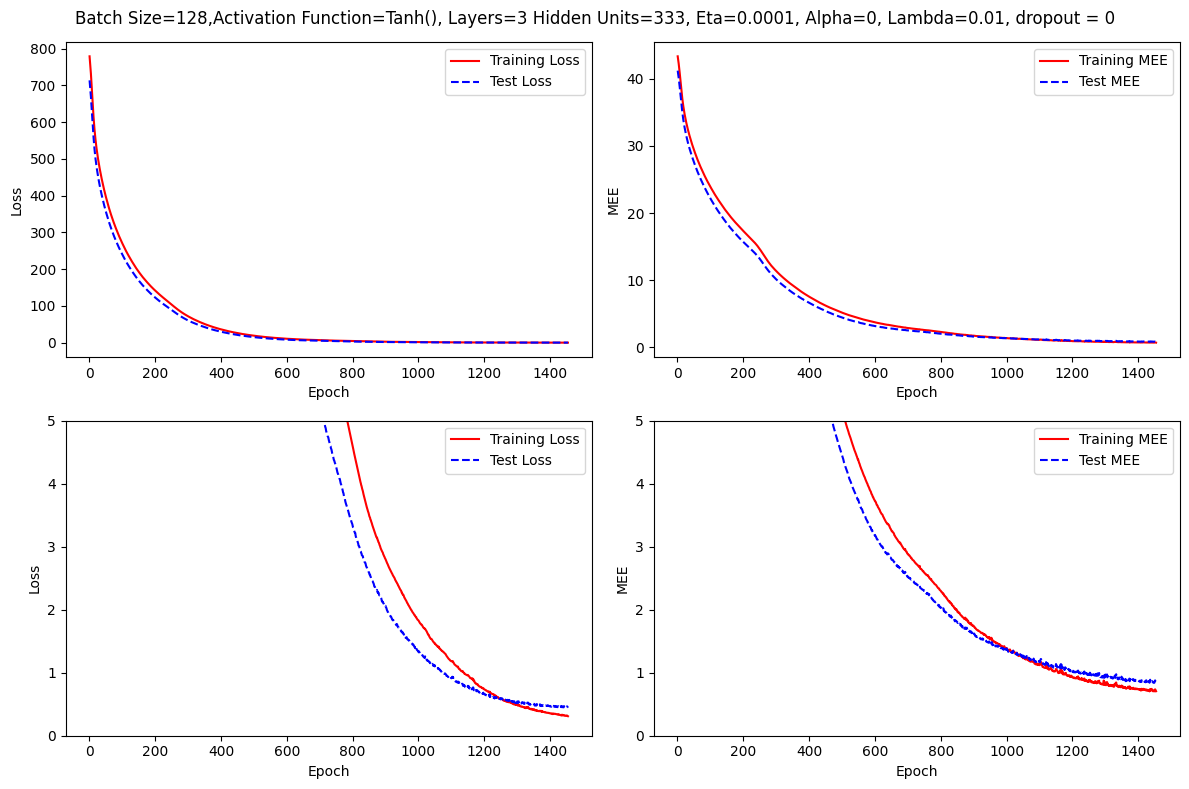

KeyboardInterrupt: 

In [255]:
'''
hidden_neurons = [100,1000] #total number of neurons
learning_rates = [1e-4,1e-5]
momentums = [0.5,0.8] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [1,2,3]
dropouts = [0]
optimiz = 'SGD' #either 'SGD' or 'Adam'
'''

'''
hidden_neurons = [1000,2000,3000] #total number of neurons
learning_rates = [1e-4]
momentums = [0.7,0.8,0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'SGD' #either 'SGD' or 'Adam'
'''

'''
hidden_neurons = [100,1000] #total number of neurons
learning_rates = [1e-4,1e-5]
momentums = [0] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [1,2,3]
dropouts = [0]
optimiz = 'Adam' #either 'SGD' or 'Adam'
'''


hidden_neurons = [1000,2000,3000] #total number of neurons
learning_rates = [1e-4]
momentums = [0] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'Adam' #either 'SGD' or 'Adam'

best_hp = perform_grid_search_kfold(hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    plot_curves=True)

In [ ]:
# train the model on all the train set using the best hyperparameters found
'''
training_model(x_train=X_train,
               y_train=y_train,
               x_test=X_test,
               y_test=y_test,
               neuron_number=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               activation= best_hp[5],
               layers= best_hp[6],
               dropout = best_hp[7]
               num_epochs=50,
               plot_curves=True)
'''

'\ntraining_model(x_train=X_train,\n               y_train=y_train,\n               x_test=X_test,\n               y_test=y_test,\n               neuron_number=best_hp[0],\n               learning_rate=best_hp[1],\n               momentum=best_hp[2],\n               bs = best_hp[3],\n               reg_coeff= best_hp[4],\n               activation= best_hp[5],\n               layers= best_hp[6],\n               dropout = best_hp[7]\n               num_epochs=50,\n               plot_curves=True)\n'

# TRAIN THE MODEL USING DIFFERENT INITIALIZATIONS

Training - Epoch [1245/5000], Loss: 0.0574, MEE: 0.3121 | Test - Epoch [1245/5000], Loss: 0.5806 MEE: 0.6899     
 N. Epochs = 1245 - Loss (train | test)= (0.05741 | 0.5806) - MEE (train | test) = (0.3120869994163513 | 0.689873218536377)


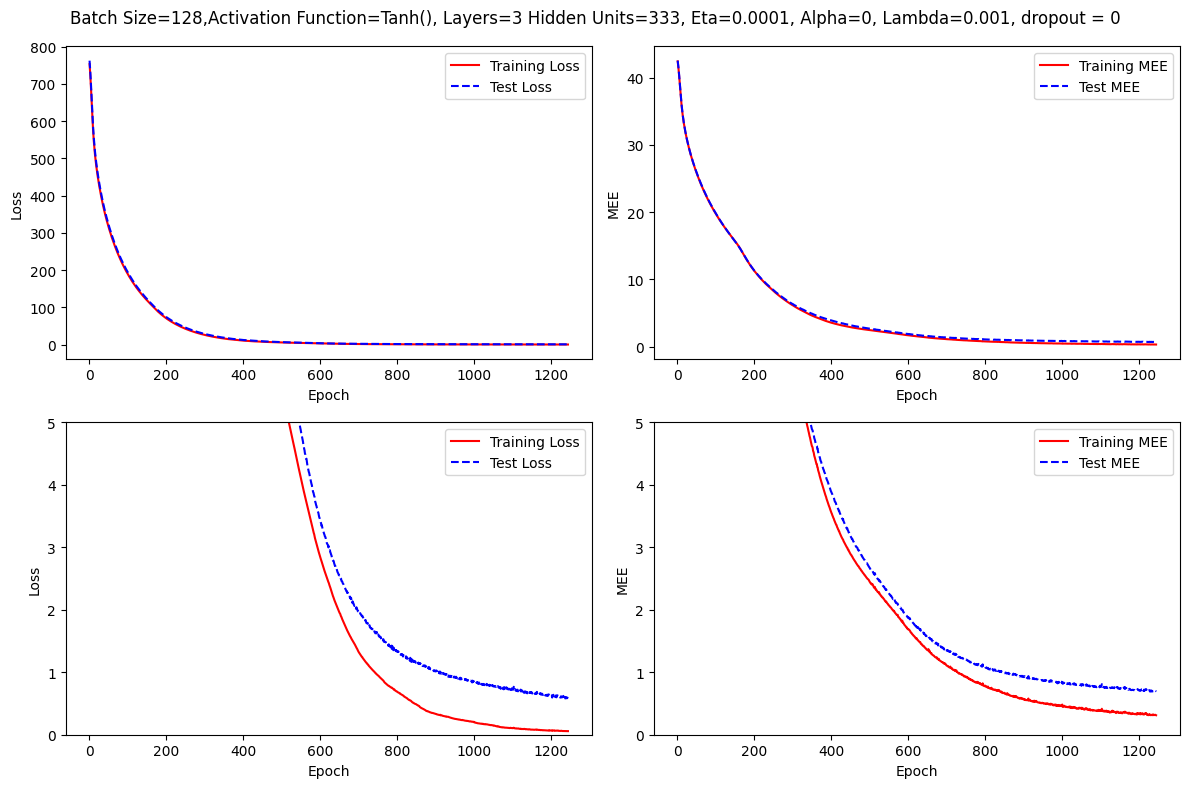

KeyboardInterrupt: 

In [ ]:
models, train_losses_hist, test_losses_hist, train_mees_hist, test_mees_hist = train_with_different_initializations(x_train=X_train,
               y_train=y_train,
               x_test=X_test,
               y_test=y_test,
               neuron_number=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               activation= best_hp[5],
               layers= best_hp[6],
               dropout= best_hp[7],
               optimiz=optimiz,
               max_num_epochs=5000,
               plot_curves=True,
               N=5)

#save models to file
for index, model in enumerate(models):
    torch.save(model,f'saved_models/trained_nn{index}.pth')

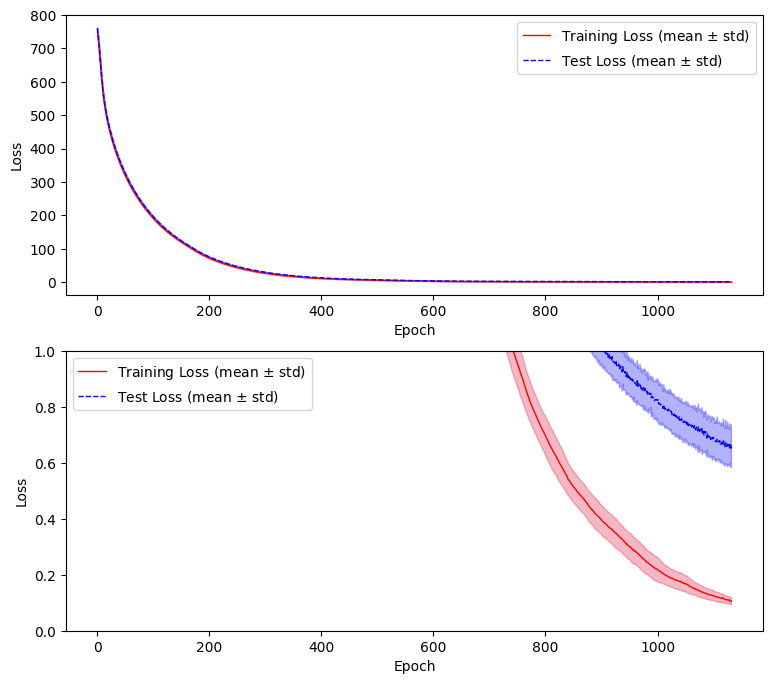

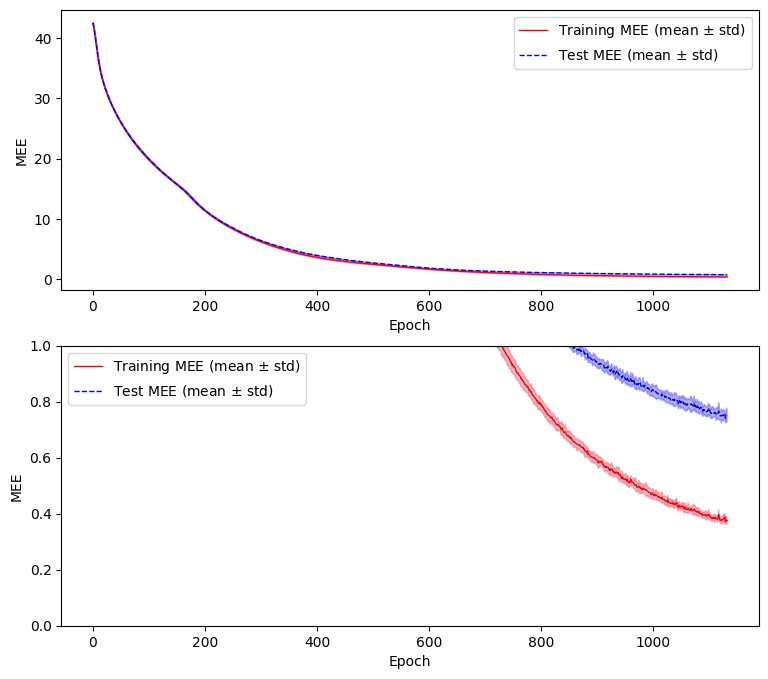

In [ ]:
plot_mean_std(N=5,train_hist=train_losses_hist,test_hist=test_losses_hist,label='Loss')
plot_mean_std(N=5,train_hist=train_mees_hist,test_hist=test_mees_hist,label='MEE')

# COMMITTEE RESPONSE

In [ ]:
#save models to file
for index, model in enumerate(models):
    torch.save(model,f'saved_models/trained_nn{index}.pth')

In [ ]:
def committee(model_name, N):
    model0 = torch.load(f'saved_models/{model_name}0.pth')
    model0.eval()
    output_sum = model0(X_test)
    #print(output_sum[0])

    for i in range(1,N):
        model = torch.load(f'saved_models/{model_name}{i}.pth')
        model.eval()
        test_outputs = model(X_test)
        #print(test_outputs[0])
        output_sum += test_outputs
        #print(output_sum[0])

    return output_sum/N


output_commitee = committee('trained_nn', N=5)
print(output_commitee.shape)
# Calculate test mee
test_mee = mean_euclidean_error(output_commitee,y_test)
print(test_mee)

torch.Size([200, 3])
0.670295774936676
